In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import spacy
import time
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import gensim


from sklearn.metrics import precision_recall_fscore_support 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


Using TensorFlow backend.


In [2]:
df = pd.read_json('DiSmldata.json')

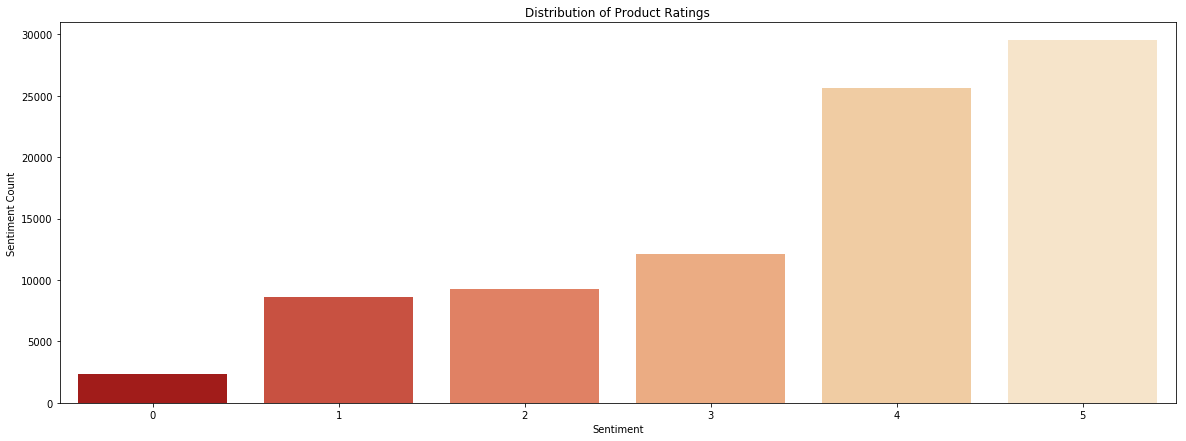

In [3]:
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=df["label"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings", \
       xlabel="Sentiment", ylabel="Sentiment Count")
plt.show()

In [4]:
my_stop_words = ENGLISH_STOP_WORDS.union(['disneyland','tokyo','disney', 'im', 'tdrnow','paris','california','amp','disneysea','got',
                                         'ºc', 'ºf', 'ºoº','𝗧𝗵𝗲','くまのプーさん', 'ディズニー', 'ディズニーシー','ディズニーハロウィーン',
                                         'ディズニーランド', 'ディズニー好きと繋がりたい', 'フェスティバルオブミスティーク', 'マルマン',
                                         'ㅋㅋㅋ', '場所', '更新', '月released', '東京ディズニーシー', '東京ディズニーランド', '東京ディズニーリゾート',
                                         '香港迪士尼樂園', 'ºº', 'hong', 'kong',"disneylandresort", "disneyland", "disneyresort",
                                          "californiaadventure",'downtowndisney','disneyanaheim','disneylandanaheim',
                                          'disneycalifornia','californiadisney','disneysea', 'disneytokyo', 'disneytokyoresort', 
                                          'tokyodisney','tokyodisneyresort', 'tokyodisneyland','東京ディズニーランド', 'ディズニーランド',
                                          '東京ディズニーシー', 'ズニーシー', 'tdr_now', 'tdr_md','tdr','dca','dl'])

In [6]:
#Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(df[['hash_count', 'emoji_count','clean_text',
                                                        'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']], df['label'],test_size =0.20, random_state = 77)

In [71]:
#Count vectorizer Document term matrix
count_vect = CountVectorizer(stop_words = my_stop_words, min_df = 0.005)
count_vect_fit = count_vect.fit(X_train['clean_text'])

count_train = count_vect_fit.transform(X_train['clean_text'])
count_test = count_vect_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [72]:
X_train_vect.shape

(70008, 230)

In [73]:
#Balance the Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [74]:
X_resampled_ros_test, y_resampled_ros_test = ros.fit_resample(X_test_vect.values, y_test.values)
print(sorted(Counter(y_resampled_ros_test).items()))

[(0, 5982), (1, 5982), (2, 5982), (3, 5982), (4, 5982), (5, 5982)]


In [75]:
#Random Forest

#Instantiate our model 
rf = RandomForestClassifier(n_estimators=50, max_depth=1000, n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_resampled_ros_test)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_ros_test).sum()/len(y_pred), 3)))

Fit time: 12.105 / Predict time: 0.356 ---- Precision: 0.617 / Recall: 0.589 / Accuracy: 0.589


In [76]:
#Random Forest tells our Feature Importances
importances = rf.feature_importances_
(sorted(zip(importances, X_train_vect.columns), reverse=True))[0:20]

[(0.1303768456287617, 'tweet_len'),
 (0.07807822616226266, 'cap_count'),
 (0.07010841356118133, 'punc_count'),
 (0.057022406417206975, 'hash_count'),
 (0.02898339490109582, 'sadness'),
 (0.02687734180905905, 'emoji_count'),
 (0.025203949296349795, 'joy'),
 (0.023096638219575978, 'fear'),
 (0.01948154748113576, 'anticipation'),
 (0.01909843941302194, 'anger'),
 (0.017722890983914507, 'trust'),
 (0.014656758600497581, 'disgust'),
 (0.012118719656079035, 'surprise'),
 (0.011720533443747589, 29),
 (0.010807713899821336, 90),
 (0.0077703141307843265, 197),
 (0.0071537028588388495, 31),
 (0.006016422446220515, 69),
 (0.005973557340930049, 64),
 (0.005850698696712951, 181)]

In [77]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB()

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_resampled_ros_test)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), 
    round(recall, 3), round((y_pred==y_resampled_ros_test).sum()/len(y_pred), 3)))

Fit time: 3.642 / Predict time: 0.07 ---- Precision: 0.518 / Recall: 0.514 / Accuracy: 0.514


In [78]:
#Logistic Regression 

#Instantiate our model
lr = LogisticRegression(max_iter = 100, solver = 'lbfgs')

#Train our Model
start = time.time()
lr.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = lr.predict(X_resampled_ros_test)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), 
    round((y_pred==y_resampled_ros_test).sum()/len(y_pred), 3)))

Fit time: 7.365 / Predict time: 0.045 ---- Precision: 0.459 / Recall: 0.444 / Accuracy: 0.444


/Users/justin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### TFIDF

In [79]:
#TFIDF vector DTM
tfidf_vect = TfidfVectorizer(stop_words = my_stop_words, min_df = 0.005)
tfidf_vect_fit = tfidf_vect.fit(X_train['clean_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['clean_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['clean_text'])

X_train_vect_tf = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect_tf = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

In [80]:
X_train_vect_tf.shape

(70008, 230)

In [81]:
#Balance the Data 
ros = RandomOverSampler(random_state=77) 
X_resampled_ros_tf, y_resampled_ros_tf = ros.fit_resample(X_train_vect_tf.values, y_train.values)
print(sorted(Counter(y_resampled_ros_tf).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [82]:
X_resampled_ros_test_tf, y_resampled_ros_test_tf = ros.fit_resample(X_test_vect_tf.values, y_test.values)
print(sorted(Counter(y_resampled_ros_test_tf).items()))

[(0, 5982), (1, 5982), (2, 5982), (3, 5982), (4, 5982), (5, 5982)]


In [83]:
#Random Forest

#Instantiate our model 
rf = RandomForestClassifier(n_estimators=50, max_depth=1000, n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros_tf, y_resampled_ros_tf)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_resampled_ros_test_tf)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test_tf, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_ros_test_tf).sum()/len(y_pred), 3)))

Fit time: 12.138 / Predict time: 0.349 ---- Precision: 0.614 / Recall: 0.584 / Accuracy: 0.584


In [84]:
#Random Forest tells our Feature Importances
importances = rf.feature_importances_
(sorted(zip(importances, X_train_vect_tf.columns), reverse=True))[0:20]

[(0.12106733725450405, 'tweet_len'),
 (0.07098867227488843, 'cap_count'),
 (0.06614191209394779, 'punc_count'),
 (0.05582949659414724, 'hash_count'),
 (0.027689268039805655, 'sadness'),
 (0.024820731788330032, 'fear'),
 (0.024271540740605047, 'emoji_count'),
 (0.023564576692525548, 'joy'),
 (0.0169774729545499, 'anticipation'),
 (0.01645790531903967, 'trust'),
 (0.015490519161953504, 'anger'),
 (0.01510264703412933, 'disgust'),
 (0.012640094971237843, 90),
 (0.012188790678675869, 29),
 (0.011220898542607742, 'surprise'),
 (0.008626177314886676, 197),
 (0.00830021294399549, 181),
 (0.008278631893969943, 31),
 (0.006798141052192894, 64),
 (0.006744256438246525, 69)]

In [85]:
#Multinomial Bayes

#Instantiate our model 
nb_clf = MultinomialNB()

#Train our Model 
start = time.time()
nb_clf.fit(X_resampled_ros_tf, y_resampled_ros_tf)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = nb_clf.predict(X_resampled_ros_test_tf)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test_tf, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_ros_test_tf).sum()/len(y_pred), 3)))

Fit time: 0.11 / Predict time: 0.016 ---- Precision: 0.499 / Recall: 0.495 / Accuracy: 0.495


In [86]:
#Logistic Regression 

#Instantiate our model
lr = LogisticRegression(max_iter = 100, solver = 'lbfgs')

#Train our Model
start = time.time()
lr.fit(X_resampled_ros_tf, y_resampled_ros_tf)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = lr.predict(X_resampled_ros_test_tf)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test_tf, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_ros_test_tf).sum()/len(y_pred), 3)))

Fit time: 7.746 / Predict time: 0.012 ---- Precision: 0.438 / Recall: 0.425 / Accuracy: 0.425


/Users/justin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


##### Word2Vec

In [87]:
from nltk.tokenize import word_tokenize
tokenized_tweet = df.clean_text.apply(word_tokenize)

In [88]:
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=230, # desired no. of features/independent variables 
            window=3, # context window size
            min_count=30,
            sg = 1, # 1 for skip-gram model
            seed = 77)

model_w2v.train(tokenized_tweet, total_examples= len(df['clean_text']), epochs=20)

(12701458, 17727920)

In [89]:
model_w2v.wv.most_similar("tokyo")

[('disneysea', 0.5430849194526672),
 ('disneylandtokyo', 0.46373534202575684),
 ('東京ディズニーリゾート', 0.39844822883605957),
 ('sea', 0.3980148136615753),
 ('steamer', 0.39004385471343994),
 ('tokyodisney', 0.37289878726005554),
 ('tue', 0.3697461485862732),
 ('port', 0.3695187270641327),
 ('transit', 0.36897897720336914),
 ('chiba', 0.368430495262146)]

In [90]:
model_w2v.wv.most_similar("fun")

[('bff', 0.39314982295036316),
 ('blast', 0.3678790330886841),
 ('sundayfunday', 0.32133573293685913),
 ('vote', 0.3198425769805908),
 ('memories', 0.3136768043041229),
 ('awesome', 0.30930376052856445),
 ('enjoyed', 0.3059080243110657),
 ('enjoying', 0.30518752336502075),
 ('cosplay', 0.3031541705131531),
 ('spooktacular', 0.3029031455516815)]

In [91]:
model_w2v.wv.most_similar("anaheim")

[('disneyjobs', 0.3763093650341034),
 ('annualpassholder', 0.34122025966644287),
 ('themeparks', 0.3221602737903595),
 ('losangeles', 0.3192991614341736),
 ('harbor', 0.31923311948776245),
 ('socal', 0.31771254539489746),
 ('gaydays', 0.3149857819080353),
 ('district', 0.31309419870376587),
 ('goofys', 0.3083474636077881),
 ('california', 0.3052617311477661)]

In [92]:
model_w2v.wv.most_similar("boring")

[('bullshit', 0.40894144773483276),
 ('fucked', 0.40067780017852783),
 ('rage', 0.36938905715942383),
 ('human', 0.36319437623023987),
 ('losing', 0.3567168712615967),
 ('ball', 0.35210132598876953),
 ('lack', 0.3520182967185974),
 ('brain', 0.3508557379245758),
 ('confused', 0.3503156900405884),
 ('umbrella', 0.3469950556755066)]

In [93]:
model_w2v.wv.most_similar("disney")

[('disneyfan', 0.519191563129425),
 ('disneyfans', 0.4954191744327545),
 ('disneyig', 0.4932956397533417),
 ('disneyaddict', 0.49034011363983154),
 ('disneyland', 0.4743539094924927),
 ('disneymagic', 0.4639242887496948),
 ('disneylove', 0.46227356791496277),
 ('disneystyle', 0.44713208079338074),
 ('instadisney', 0.44141948223114014),
 ('disneyparks', 0.43604254722595215)]

In [94]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [96]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 230))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 230)

wordvec_df = pd.concat([df[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(wordvec_arrays)], axis=1)

/Users/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [97]:
wordvec_df

,hash_count,emoji_count,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,...,220,221,222,223,224,225,226,227,228,229
0,1,0,0,0,0,0,0,0,0,0,...,-0.045284,-0.079552,0.093554,0.043960,0.028761,0.080055,0.072261,-0.102041,-0.080967,0.049143
1,1,0,0,1,0,0,0,0,0,0,...,-0.117812,0.019281,-0.072755,-0.102343,0.205131,0.159179,-0.055840,-0.087664,-0.051933,0.072010
2,0,0,0,0,0,0,0,0,0,0,...,0.088095,0.056327,-0.076466,0.027169,-0.124262,0.073991,0.100744,-0.075328,-0.201656,0.097621
3,1,0,0,0,0,0,0,0,0,0,...,-0.251371,-0.048714,0.191657,0.104738,0.066017,0.154219,0.200543,-0.210700,-0.070858,-0.040129
4,0,0,0,1,0,1,1,0,0,1,...,0.067614,0.054041,-0.019578,-0.034596,0.050744,0.033172,0.063536,-0.074226,-0.051851,0.057051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87505,3,0,0,0,0,0,0,0,0,0,...,-0.219816,-0.169808,-0.157795,-0.054618,-0.047840,0.293229,-0.039973,0.030857,-0.039618,-0.102461
87506,1,1,1,2,0,1,4,1,4,4,...,-0.272423,-0.363468,-0.109325,0.039305,-0.080120,0.232073,-0.017409,0.204312,-0.154984,0.541024
87507,0,0,0,0,0,0,0,0,0,0,...,0.055245,-0.048646,-0.186082,-0.032606,0.008366,-0.078292,0.032201,-0.106753,0.251502,-0.124243
87508,0,0,0,1,0,0,1,0,0,0,...,-0.101566,-0.135424,-0.203906,-0.071573,-0.062181,0.030170,0.011955,0.049640,-0.100044,0.016892


In [98]:
# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(wordvec_df, df['label'],  
                                                          random_state=77, 
                                                          test_size=0.2)

In [99]:
#Balance the Data 
ros = RandomOverSampler(random_state=77) 
X_resampled_w2vec, y_resampled_w2vec = ros.fit_resample(xtrain_bow.values, ytrain.values)
print(sorted(Counter(y_resampled_w2vec).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [100]:
X_resampled_w2vec_t, y_resampled_w2vec_t = ros.fit_resample(xvalid_bow.values, yvalid.values)
print(sorted(Counter(y_resampled_w2vec_t).items()))

[(0, 5982), (1, 5982), (2, 5982), (3, 5982), (4, 5982), (5, 5982)]


In [102]:
#Random Forest

#Instantiate our model 
rf = RandomForestClassifier(n_estimators=50, max_depth=1000, n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_w2vec, y_resampled_w2vec)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_resampled_w2vec_t)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_w2vec_t, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_w2vec_t).sum()/len(y_pred), 3)))

Fit time: 20.571 / Predict time: 0.236 ---- Precision: 0.417 / Recall: 0.364 / Accuracy: 0.364


In [103]:
#Random Forest tells our Feature Importances
importances = rf.feature_importances_
(sorted(zip(importances, xtrain_bow.columns), reverse=True))[0:20]

[(0.0298787766668389, 'hash_count'),
 (0.02638732207990354, 'tweet_len'),
 (0.018613391096563698, 'joy'),
 (0.018224906714123034, 'sadness'),
 (0.016765954856981746, 'fear'),
 (0.014607287266884952, 'punc_count'),
 (0.012607334110587693, 'cap_count'),
 (0.00934111906917256, 'anger'),
 (0.00821606744911832, 'disgust'),
 (0.007404822906164451, 'anticipation'),
 (0.007172041882647434, 'trust'),
 (0.0040809334133001555, 'surprise'),
 (0.0039594486196118965, 'emoji_count'),
 (0.003867090805706925, 76),
 (0.003809663756012949, 159),
 (0.0037864113486686685, 101),
 (0.003784440279148222, 123),
 (0.0037709644625289664, 189),
 (0.003757757808505309, 221),
 (0.0037573237271764266, 133)]

In [124]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

#Instantiate our model 
knn = KNeighborsClassifier(n_neighbors = 6)

#Model Fit 
start = time.time()
knn.fit(X_resampled_w2vec, y_resampled_w2vec)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = knn.predict(X_resampled_w2vec_t)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_w2vec_t, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_w2vec_t).sum()/len(y_pred), 3)))

Fit time: 5.932 / Predict time: 47.942 ---- Precision: 0.333 / Recall: 0.329 / Accuracy: 0.329


In [121]:
#Logistic Regression 

#Instantiate our model
lr = LogisticRegression(max_iter = 10, solver = 'lbfgs')

#Train our Model
start = time.time()
lr.fit(X_train_scaled, y_resampled_w2vec)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = lr.predict(X_test_scaled)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_w2vec_t, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_w2vec_t).sum()/len(y_pred), 3)))

Fit time: 0.655 / Predict time: 0.009 ---- Precision: 0.399 / Recall: 0.391 / Accuracy: 0.391


/Users/justin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
